<a href="https://colab.research.google.com/github/abou96/WorldBankProject/blob/dev/World_Bank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install wbgapi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
# Libraries & Dependencies
## wbgapi has a pandas support

In [70]:
import wbgapi as wb
import pandas as pd
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import matplotlib

In [71]:
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [ ]:
# Query the environmental score, methane emission (kt of CO2 equivalent)

In [5]:
wb.series.info(q='methane')

id,value
EN.ATM.METH.AG.KT.CE,Agricultural methane emissions (thousand metric tons of CO2 equivalent)
EN.ATM.METH.AG.ZS,Agricultural methane emissions (% of total)
EN.ATM.METH.EG.KT.CE,Methane emissions in energy sector (thousand metric tons of CO2 equivalent)
EN.ATM.METH.EG.ZS,Energy related methane emissions (% of total)
EN.ATM.METH.KT.CE,Methane emissions (kt of CO2 equivalent)
EN.ATM.METH.ZG,Methane emissions (% change from 1990)
,6 elements


idea of the metrics :
At standard temperature and pressure, one metric ton of carbon dioxide (CO₂) would fill a sphere 32 feet (about 9.8 meters) in diameter. The average car in the U.S. will produce this over a three-month period.

In [17]:
wb.data.DataFrame(['NY.GDP.PCAP.CD', 'SP.POP.TOTL'], 'CAN', mrv=5) # most recent 5 years 

,YR2017,YR2018,YR2019,YR2020,YR2021
series,,,,,
NY.GDP.PCAP.CD,4.512943e+04,4.654864e+04,4.632867e+04,4.325826e+04,5.198794e+04
SP.POP.TOTL,3.654524e+07,3.706508e+07,3.760123e+07,3.803720e+07,3.824611e+07


In [20]:
QUERY_ID = 'EN.ATM.METH.EG.KT.CE'

In [121]:
def getDataMethEmissionByCountryAndYears(CountryAlpha2Code: str, period_time: list) -> pd.DataFrame :
  df = wb.data.DataFrame(QUERY_ID, CountryAlpha2Code, time = period_time, columns='series')
  return df.reset_index()


In [122]:
df = getDataMethEmissionByCountryAndYears('SEN', 'all')

In [123]:
df

,time,EN.ATM.METH.EG.KT.CE
0,YR1960,NaN
1,YR1961,NaN
2,YR1962,NaN
3,YR1963,NaN
4,YR1964,NaN
...,...,...
57,YR2017,290.0
58,YR2018,290.0
59,YR2019,300.0
60,YR2020,NaN


Cleaning Data

In [124]:
def CleaningAndRename(df):
  df['date'] = df['time'].str[2:]
  df = df.rename(columns = {'EN.ATM.METH.EG.KT.CE' : 'ktofCO2'})
  del df['time']
  return df.set_index('date')



In [126]:
df = CleaningAndRename(df)

In [133]:
df

,ktofCO2
date,
1960,NaN
1961,NaN
1962,NaN
1963,NaN
1964,NaN
...,...
2017,290.0
2018,290.0
2019,300.0


In [129]:
df.isnull().sum()

ktofCO2    32
dtype: int64

In [ ]:
def HandlingMissingValue(df) :
  df.isnull().sum()

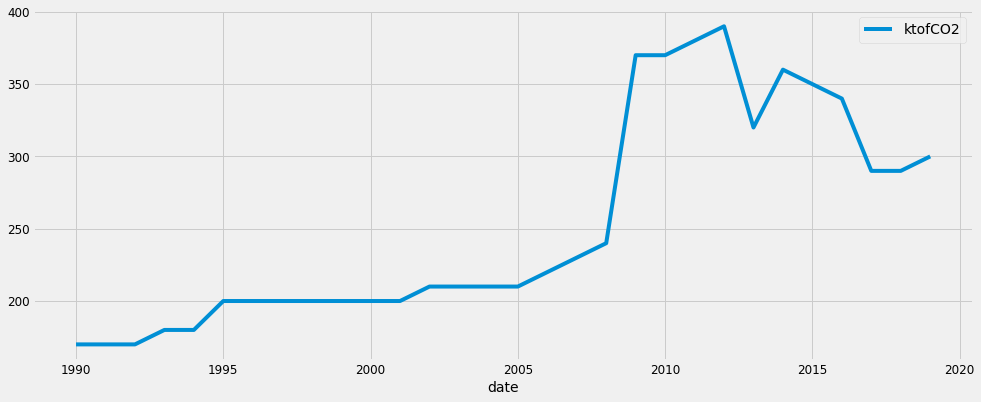

In [128]:
df.plot(figsize=(15, 6))
plt.show()